In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
# os.environ['WANDB_MODE']='offline'
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from albumentations.pytorch import ToTensorV2

import albumentations as A
import monai

from colorama import Fore, Back, Style
c_  = Fore.GREEN
sr_ = Style.RESET_ALL

import time
from collections import defaultdict
import copy
import gc

from utils.dataset import EchoDataset_heatmap
from utils.train import *
from utils.evaluation import *
from utils.optimizer import *
from utils.utils import *

import wandb
import warnings

warnings.filterwarnings("ignore")
os.environ['PYTORCH_ENABLE_MPS_FALLBACK']='1'


In [3]:
### Logging part
import logging
from datetime import datetime
from pytz import timezone
import sys

import random

def log(CFG):
    logger = logging.getLogger()
    logger.setLevel(logging.INFO)
    def timetz(*args):
        return datetime.now(tz).timetuple()
    tz = timezone('Asia/Seoul')
    logging.Formatter.converter = timetz

    formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    # log 출력
    stream_handler = logging.StreamHandler()
    stream_handler.setFormatter(formatter)
    logger.addHandler(stream_handler)

    # log를 파일에 출력
    file_handler = logging.FileHandler(os.path.join(CFG['save_path'], f"{CFG['view']}-{CFG['dataset']}-{CFG['backbone']}.log"))
    file_handler.setFormatter(formatter)
    logger.addHandler(file_handler)

    logger.info(f"python {' '.join(sys.argv)}")
    logger.info("Timezone: " + str(tz))
    logger.info(f"Training Start")
    return logger


In [4]:
def seed_everything(seed: int=0):    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
seed_everything()

## ⚙️ Configuration

In [5]:
view2cls_dict = {
    'PLAX': 3,
    'PSAX': 0,
    '2CH': 2,
    '4CH': 2,
}
class cfg:
    def __getitem__(self,key):
        return getattr(self, key)
    def __setitem__(self,key,value):
        return setattr(self, key, value)

    height = 480   
    width = 640
    view = 'PLAX'
    # dataset = 'EchoNetLVH_datasetV2'
    lr = 5e-3
    scheduler = 'LambdaLR'
    reducelr_factor = 0.99
    min_lr = 1e-5
    device = torch.device('cpu') # 수정필요
    epochs = 25
    patience = 100
    batch_size = 2

    ############## Heatmap hyperparameter
    std = 15
    ##############
    model = 'UNet'
    backbone = 'resnet34'
    # version = 'resnet101_imagenet'
    
CFG = cfg()
CFG['save_path'] = os.path.join('saved_model', '_'.join([CFG['model'], CFG['version']]))
os.makedirs(CFG['save_path'], exist_ok=True)

In [6]:
logger = log(CFG)
trace_func = logger.info

2022-11-05 12:22:41,868 - python /opt/homebrew/Caskroom/miniconda/base/envs/torch/lib/python3.8/site-packages/ipykernel_launcher.py -f /Users/kyh/Library/Jupyter/runtime/kernel-f14f0a22-39c9-41e3-bc73-f4cd9bfb6337.json


2022-11-05 12:22:41,868 - root - INFO - python /opt/homebrew/Caskroom/miniconda/base/envs/torch/lib/python3.8/site-packages/ipykernel_launcher.py -f /Users/kyh/Library/Jupyter/runtime/kernel-f14f0a22-39c9-41e3-bc73-f4cd9bfb6337.json


2022-11-05 12:22:41,869 - Timezone: Asia/Seoul


2022-11-05 12:22:41,869 - root - INFO - Timezone: Asia/Seoul


2022-11-05 12:22:41,869 - Training Start


2022-11-05 12:22:41,869 - root - INFO - Training Start


In [30]:
dataset_dir = '../meta_dataset/4CH/' # 수정필요
CFG['dataset'] = dataset_dir.split('/')[-1]

## 📀 Load Data

In [31]:
from albumentations.core.transforms_interface import ImageOnlyTransform

class MinMaxNormalize(ImageOnlyTransform):
    """
    Min-max normalization
    """
    def apply(self, img, **param):
        # minmax normalize
        # img = (img - img.min()) / (img.max() - img.min())
        img = img / 255.
        return img


In [32]:
train_ts = A.Compose([
    A.Resize(CFG['height'], CFG['width']),
    # A.HorizontalFlip(p=.5),
    # A.VerticalFlip(p=.3),
    # # A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2,
    # #                 rotate_limit=10, p=0.2),
    # A.SafeRotate(limit=30),

    # A.OneOf([
    #     A.MedianBlur(blur_limit=3, p=0.1),
    #     A.MotionBlur(p=0.2),
    # ], p=0.2),
    # # A.OneOf([
    # #     A.OpticalDistortion(p=0.3),
    # # ], p=0.2),
    # A.OneOf([
    #     A.GaussNoise(p=0.2),
    #     A.MultiplicativeNoise(p=0.2),
    # ], p=0.2),
    # A.HueSaturationValue(hue_shift_limit=0, sat_shift_limit=0,
    #                      val_shift_limit=0.1, p=0.3),
    MinMaxNormalize(p=1),

    ToTensorV2(),

],
    keypoint_params=A.KeypointParams(format='xy')
)
test_ts = A.Compose([
        A.Resize(CFG['height'], CFG['width']),
        MinMaxNormalize(p=1),
        ToTensorV2(),
        ],
        keypoint_params=A.KeypointParams(format='xy')
        )


In [33]:
ds = EchoDataset_heatmap(root=dataset_dir, split='train', transforms=train_ts)
dl = DataLoader(ds, batch_size=1, shuffle=False, )
s = dl.__iter__().__next__()
s['data'].shape

torch.Size([1, 3, 480, 640])

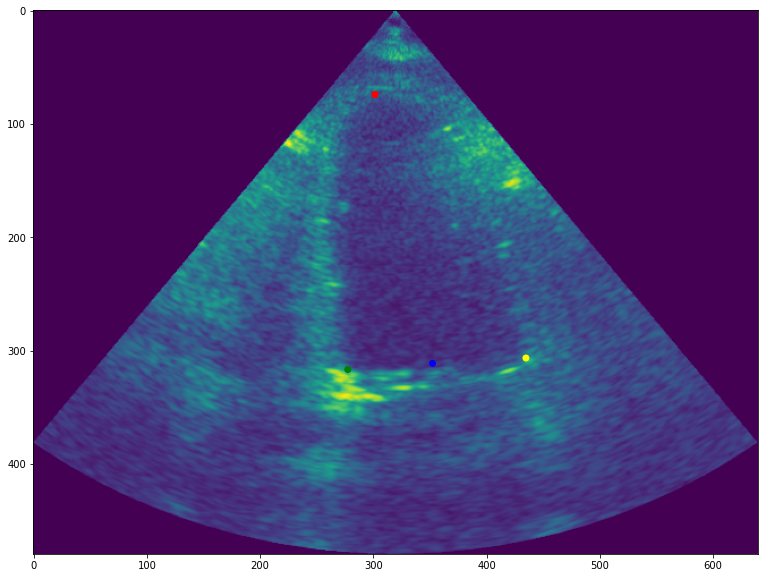

In [35]:
plt.figure(figsize=(15,10))
plt.imshow(s['data'][0][0])
plt.scatter(s['label'][0][:,0], s['label'][0][:,1], c=['red','blue','green','yellow'])

In [46]:
train_ds = EchoDataset_heatmap(root=dataset_dir, split='train', transforms=train_ts)
valid_ds = EchoDataset_heatmap(root=dataset_dir, split='val', transforms=test_ts)

train_dl = DataLoader(train_ds, batch_size=CFG.batch_size, shuffle=True, drop_last=True)
valid_dl = DataLoader(valid_ds, batch_size=CFG.batch_size//2, shuffle=False)

In [48]:
len(train_dl.dataset), len(valid_dl.dataset)

(148, 30)

## 🧮 Load Model

In [49]:
# https://github.com/echonet/lvh/blob/master/models.py
import torch
import torchvision
from pathlib import Path

class PlaxModel(torch.nn.Module):

    """Model used for prediction of PLAX measurement points.
    Output channels correspond to heatmaps for the endpoints of
    measurements of interest.
    """

    def __init__(self, 
            measurements=['LVPW', 'LVID', 'IVS'], 
        ) -> None:
        super().__init__()
        self.model = torchvision.models.segmentation.deeplabv3_resnet50(num_classes=len(measurements) + 1)

    def forward(self, x):
        return torch.sigmoid(self.model(x)['out'])


In [39]:
from utils.train_heatmap import train_one_epoch, valid_one_epoch

In [40]:

def run_training(model, train_dl, val_dl, optimizer, scheduler, criterion, CFG, wandb):
    """
    모델, 데이터를 받아 학습/검증 수행후 결과에 대해 출력 및 모델 저장
    """
    device = CFG['device']
    num_epochs = CFG['epochs']
    start = time.time()
    early_stopping = EarlyStopping(patience=CFG['patience'], verbose=True, trace_func=trace_func)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_mde = np.inf
    best_metric_epoch = -1

    best_loss = np.inf
    best_loss_epoch = -1

    history = defaultdict(list)
    # 에폭만큼 학습 수행
    for epoch in range(1, num_epochs+1):
        gc.collect()
        # 에폭 단위 학습 수행
        train_loss, train_mde = train_one_epoch(model=model, dataloader=train_dl, optimizer=optimizer, scheduler=scheduler, device=device, criterion=criterion, CFG=CFG)
        # 에폭 단위 검증 수행
        val_loss, val_mde = valid_one_epoch(model=model, dataloader=val_dl, device=device, criterion=criterion, CFG=CFG)
        early_stopping(val_loss, model)

        history['Train Loss'].append(train_loss)
        history['Train MDE'].append(train_mde)
        history['Valid Loss'].append(val_loss)
        history['Valid MDE'].append(val_mde)
        
        wandb.log({"Train Loss": train_loss, 
            "Train MDE": train_mde,
            "Valid Loss": val_loss,
            "Valid MDE": val_mde,
            "LR":scheduler.get_last_lr()[0]})

        trace_func(f"[Epoch {epoch}/{CFG['epochs']}: Train Loss: {train_loss:.5f}, Val Loss: {val_loss:.5f}, Train MDE: {train_mde:.5f}, Val MDE: {val_mde:.5f}")
        
        if scheduler is not None:
            scheduler.step()

        # Val MDE가 개선된 경우
        if val_mde <= best_mde:
            trace_func(f"Valid Score Improved ({best_mde:.4f} ---> {val_mde:.4f})")
            best_mde = val_mde
            best_metric_epoch = epoch
            best_metric_model_wts = copy.deepcopy(model.state_dict())
            
            wandb.run.summary['Best MDE'] = best_mde
            wandb.run.summary['Best Metric Epoch'] = best_metric_epoch

            model_name = f"best_metric_epoch-{CFG['view']}-{CFG['dataset']}-{CFG['backbone']}.pth"
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict':optimizer.state_dict(),
                'loss': val_loss,
                'metric': val_mde
                }, 
                os.path.join(CFG['save_path'], model_name))

            trace_func(f"Model Saved")

        # Loss 개선되었을때
        if val_loss <= best_loss:
            trace_func(f"Valid Loss Importved ({best_loss:.4f} ---> {val_loss:.4f})")
            best_loss = val_loss
            best_loss_epoch = epoch
            best_loss_model_wts = copy.deepcopy(model.state_dict())

            wandb.run.summary['Best MDE'] = best_mde
            wandb.run.summary['Best Loss Epoch'] = best_loss_epoch


            model_name = f"best_loss_epoch-{CFG['view']}-{CFG['dataset']}-{CFG['backbone']}.pth"
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict':optimizer.state_dict(),
                'loss': val_loss,
                'metric': val_mde
                }, 
                os.path.join(CFG['save_path'], model_name))

        if early_stopping.early_stop:
            trace_func("Early stopping")
            break

    model_name = f"last_epoch-{CFG['view']}-{CFG['dataset']}-{CFG['backbone']}.pth"
    torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict':optimizer.state_dict(),
                'loss': val_loss,
                'metric': val_mde

                }, 
                os.path.join(CFG['save_path'], model_name))
    
    end = time.time()
    time_elapsed = end-start
    trace_func("Trianing complete in {:.0f}h {:.0f}m {:.0f}s".format(time_elapsed//3600, (time_elapsed%3600)//60, (time_elapsed%3600)%60))
    trace_func("Best Val MDE: {:.4f}".format(best_loss))
    trace_func("Best Val Loss: {:.4f}".format(best_mde))

    model.load_state_dict(best_metric_model_wts)

    return model, history

In [41]:
# https://github.com/qubvel/segmentation_models.pytorch
import segmentation_models_pytorch as smp
model = smp.Unet(
    encoder_name=CFG['backbone'],        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization # 수정필요
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=5,                      # model output channels (number of classes in your dataset)
    activation='softmax'
)

In [42]:

# class DiceLoss(nn.Module):
#     def __init__(self, weight=None, size_average=True):
#         super(DiceLoss, self).__init__()

#     def forward(self, inputs, targets, smooth=1):
        
#         #comment out if your model contains a sigmoid or equivalent activation layer
#         # inputs = F.sigmoid(inputs)       
#         batch_size = inputs.size(0)
#         num_joints = inputs.size(1)
#         all_dice = 0
#         for idx in range(num_joints):
#         #flatten label and prediction tensors
#             input = inputs[:,idx].reshape(-1)
#             target = targets[:,idx].reshape(-1)
        
#             intersection = (input * target).sum()                            
#             dice = (2.*intersection + smooth)/(input.sum() + target.sum() + smooth)  
#             all_dice += dice
#         return 1 - all_dice/num_joints


In [43]:
from utils.loss import HeatmapMSELoss, HeatmapOHKMMSELoss, JointsRMSELoss
# model = PlaxModel(measurements=['IVSd','LVIDd','LVPWd'])
optimizer = torch.optim.Adam(params=model.parameters(), lr=CFG.lr)
# https://smp.readthedocs.io/en/latest/losses.html
# criterion = smp.losses.DiceLoss(mode='multiclass', from_logits=False)
criterion = HeatmapMSELoss(use_target_weight=False)
# criterion = DiceLoss(ignore_index=4)

In [44]:
CFG['device'] = 'cpu'

## Train

In [45]:
run = wandb.init(project='2022KOHI_keypoint_detection|Segmentation',
                group=CFG['version'],
                name= f"View-{CFG['view']}|Dataset-{CFG['dataset']}|Backbone-{CFG['backbone']}|CFG['version']",
                entity='kyh',
                # config={k:v for k, v in CFG.items() if '__' not in k}
                config={attr: CFG[attr] for attr in dir(CFG) if not callable(getattr(CFG, attr)) and not attr.startswith("__")},
                )

model, hist = run_training(model=model.to(CFG["device"]),
             train_dl=train_dl, 
             val_dl=valid_dl, 
             optimizer=optimizer, 
             scheduler=fetch_scheduler(CFG, optimizer), 
             criterion=criterion, 
             CFG=CFG,
             wandb=wandb)
             
wandb.run.finish()

Adjusting learning rate of group 0 to 5.0000e-03.


Train : 100%|██████████| 89/89 [03:01<00:00,  2.04s/it, lr=0.00500, train_MDE=213.3924, train_loss=240.3682] 
Valid : 0it [00:00, ?it/s]

2022-11-05 12:33:05,960 - Validation loss decreased (inf --> 0.000000))#.  Saving model ...



2022-11-05 12:33:05,960 - root - INFO - Validation loss decreased (inf --> 0.000000))#.  Saving model ...


2022-11-05 12:33:05,963 - [Epoch 1/25: Train Loss: 240.36820, Val Loss: 0.00000, Train MDE: 213.39240, Val MDE: 0.00000


2022-11-05 12:33:05,963 - root - INFO - [Epoch 1/25: Train Loss: 240.36820, Val Loss: 0.00000, Train MDE: 213.39240, Val MDE: 0.00000


Adjusting learning rate of group 0 to 4.9500e-03.
2022-11-05 12:33:05,964 - Valid Score Improved (inf ---> 0.0000)


2022-11-05 12:33:05,964 - root - INFO - Valid Score Improved (inf ---> 0.0000)


2022-11-05 12:33:06,130 - Model Saved


2022-11-05 12:33:06,130 - root - INFO - Model Saved


2022-11-05 12:33:06,132 - Valid Loss Importved (inf ---> 0.0000)


2022-11-05 12:33:06,132 - root - INFO - Valid Loss Importved (inf ---> 0.0000)
Train :  34%|███▎      | 30/89 [01:03<02:04,  2.10s/it, lr=0.00495, train_MDE=168.0885, train_loss=96.7564]


KeyboardInterrupt: 

## test

In [50]:
val_it = valid_dl.__iter__()

In [51]:
val_elem = val_it.next()

In [52]:
model.eval()
result = model.to(torch.device('cpu'))(val_elem['data'])

In [53]:
from utils.heatmaps import *
heatmap = render_gaussian_dot_f(
    val_elem['label'].flip(dims=[2]), # xy 2 yx
    torch.tensor([CFG['std'], CFG['std']], dtype=torch.float32).to('cpu'),
    [CFG['height'], CFG['width']],
    # mul=255.
    )


In [58]:
x = val_elem['label'].squeeze()

(-0.5, 639.5, 479.5, -0.5)

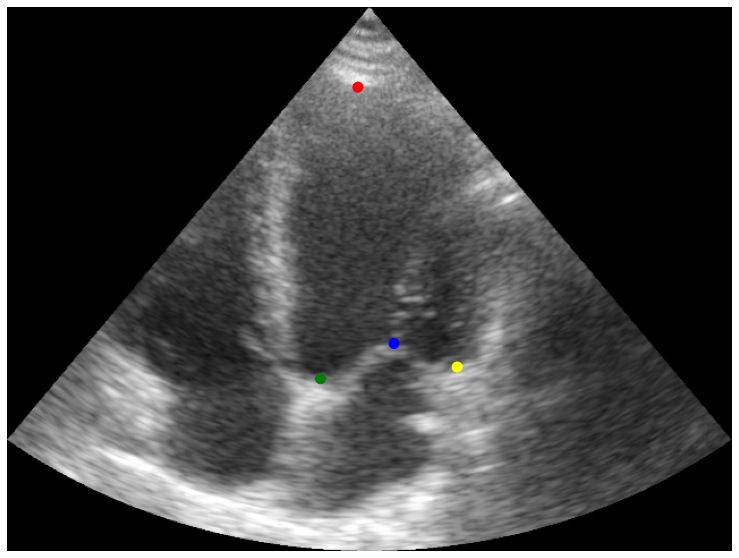

In [59]:
plt.figure(figsize=(15,10))

plt.imshow(val_elem['data'][0,0,...].numpy(), cmap='gray')
plt.scatter(x[:,0], x[:,1], c=['red', 'blue', 'green', 'yellow'], s=100)
plt.axis('off')

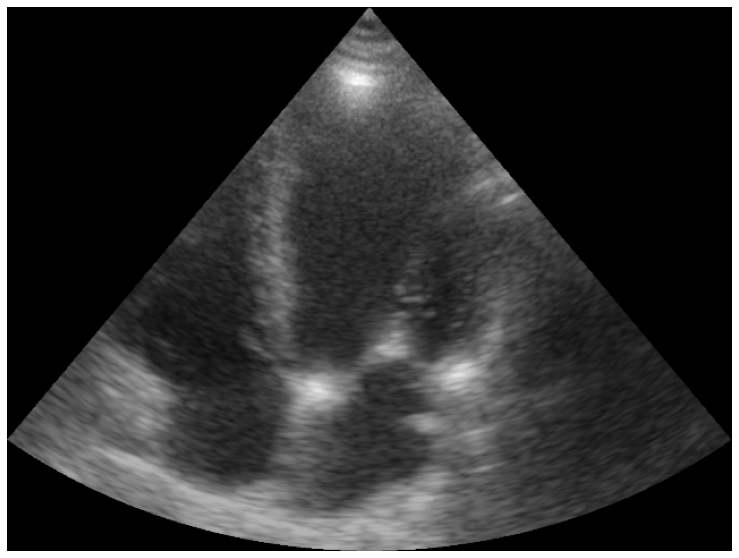

In [60]:
import cv2
i = cv2.addWeighted(val_elem['data'][0,0,...].numpy(),1,heatmap.squeeze().sum(0).numpy(),.5,0)

plt.figure(figsize=(15,10))
plt.axis('off')
plt.imshow(i, cmap='gray')

In [61]:
background = 1 - heatmap.sum(dim=1).unsqueeze(1).clip(0,1)
heatmap = torch.concat((heatmap,background), 1)

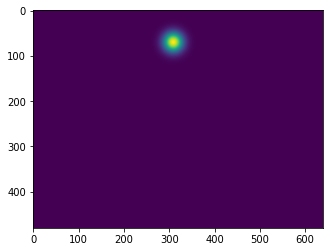

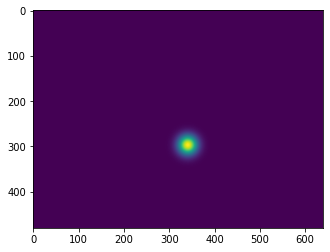

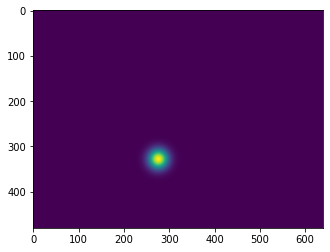

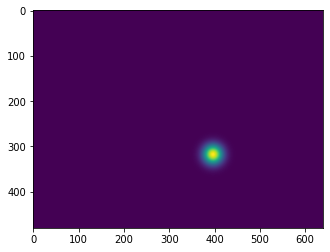

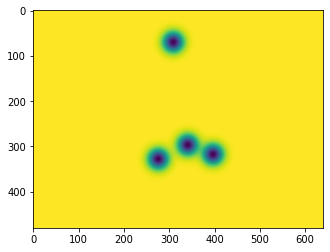

In [64]:
for i in heatmap.squeeze():
    plt.imshow(i)
    plt.show()
    # print((i==i.max()).nonzero())

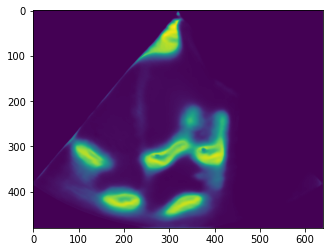

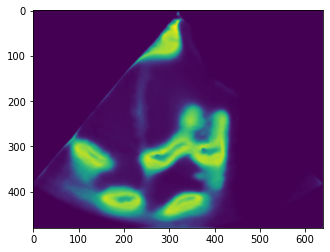

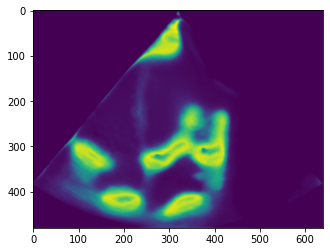

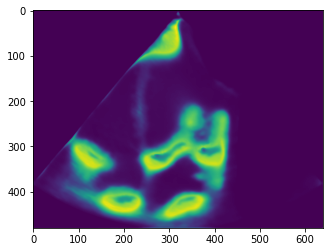

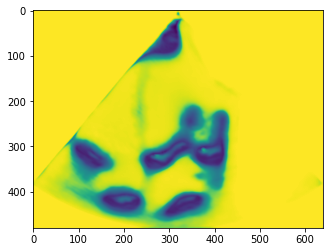

In [63]:
predicted = []
for i in result.squeeze():
    a = i.detach().clone().numpy()
    # print(a)
    # a[a<=.3]=0
    
    plt.imshow(a)
    plt.show()
    predicted.append((a==a.max()).nonzero())
